In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#load data
train_df = pd.read_csv("train_split_merged_expanded_data.csv")
val_df = pd.read_csv("val_split_merged_expanded_data.csv")
test_df = pd.read_csv("test_split_merged_expanded_data.csv")

#datetime features
train_df['date'] = pd.to_datetime(train_df['date'])
val_df['date'] = pd.to_datetime(val_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

for df in [train_df, val_df, test_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df.drop('date', axis=1, inplace=True)

for df in [train_df, val_df, test_df]:
    df = pd.get_dummies(df, columns=['weekday'], prefix='wd')

all_columns = set(train_df.columns) | set(val_df.columns) | set(test_df.columns)

for df in [train_df, val_df, test_df]:
    for col in all_columns:
        if col not in df.columns:
            df[col] = 0

train_df = train_df[sorted(train_df.columns)]
val_df   = val_df[sorted(val_df.columns)]
test_df  = test_df[sorted(test_df.columns)]


#prepare data
X_train = train_df.drop(columns=['umsatz'])
y_train = train_df['umsatz']
X_val = val_df.drop(columns=['umsatz'])
y_val = val_df['umsatz']
X_test = test_df.drop(columns=['umsatz'])
y_test = test_df['umsatz']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#define model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.005, l2=0.005), input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)), #add L2 regularization to prevent overfitting (in first row bigger weihg than here in second row)
    Dropout(0.2), #add dropout layers to prevent overfitting, 20% randomly deactivated
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

#compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#train model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history = model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, validation_data=(X_val_scaled, y_val), callbacks=[early_stop, reduce_lr])

#evaluate model
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

#save model
model.save('neural_network_model_classification.h5')

2026-01-04 20:34:40.713290: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-04 20:34:40.713783: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-04 20:34:40.811784: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-04 20:34:43.196859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: -453867.2188 - val_accuracy: 0.0000e+00 - val_loss: -2247522.7500 - learning_rate: 0.0010
Epoch 2/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: -21142038.0000 - val_accuracy: 0.0000e+00 - val_loss: -45997448.0000 - learning_rate: 0.0010
Epoch 3/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: -165031568.0000 - val_accuracy: 0.0000e+00 - val_loss: -244132304.0000 - learning_rate: 0.0010
Epoch 4/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: -632531776.0000 - val_accuracy: 0.0000e+00 - val_loss: -763805504.0000 - learning_rate: 0.0010
Epoch 5/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: -1672913536.0000 - val_accuracy: 0.0000e+00 - val_loss: -1788087808.0000 - learning_rate: 0.0010
Epoch 6/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: -3596743424.0000 - val_acc

Validation Loss: -1.0561991374536704e+16, Validation Accuracy: 0.0


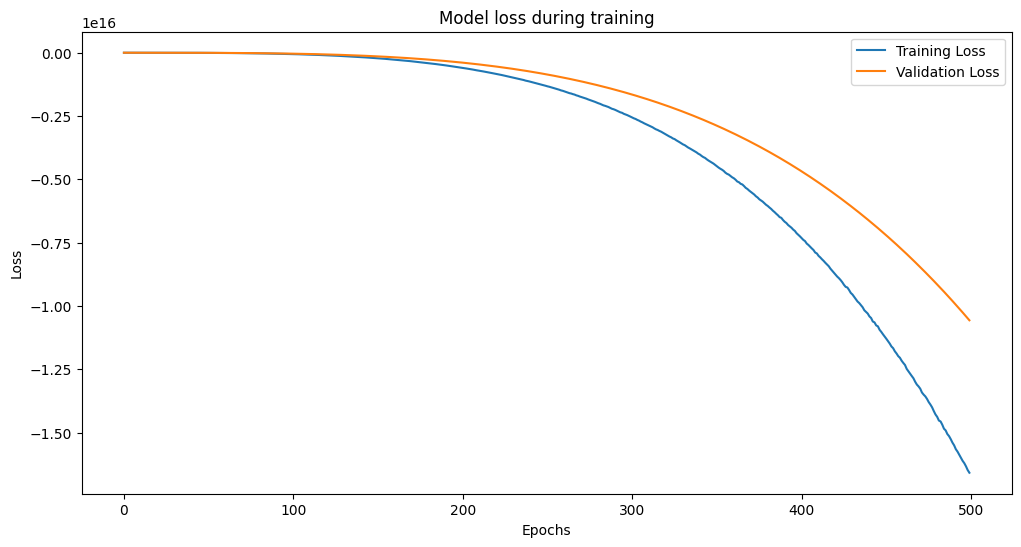

In [2]:
#plotting training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss during training')
plt.legend()
plt.show()

 1/58 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 55053.45
MAE: 195.28
R² : -2.254


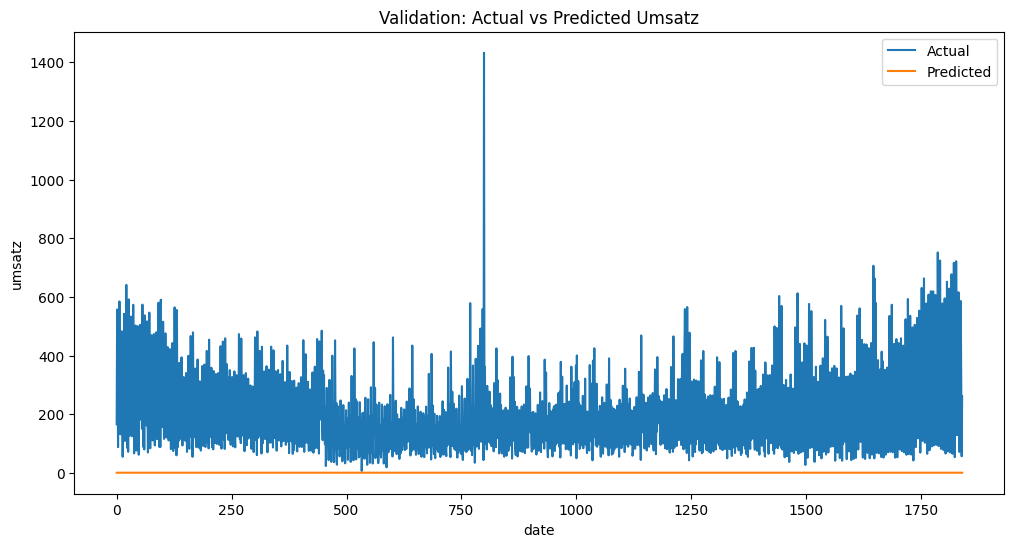

In [3]:
#predictions
future_df = X_val.copy()  #using validation data as example for future data, already without "umsatz"

X_future_scaled = scaler.transform(future_df)
future_predictions = model.predict(X_future_scaled).flatten()
future_df['predicted_umsatz'] = future_predictions

#comparison with actual values
mse = mean_squared_error(y_val, future_predictions)
mae = mean_absolute_error(y_val, future_predictions)
r2  = r2_score(y_val, future_predictions)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² : {r2:.3f}")

#visualize future predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_val.values, label='Actual')
plt.plot(future_predictions, label='Predicted')
plt.xlabel('date')
plt.ylabel('umsatz')
plt.title('Validation: Actual vs Predicted Umsatz')
plt.legend()
plt.show()

 75/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 99.25%
MAPE on the Validation Data: 99.23%


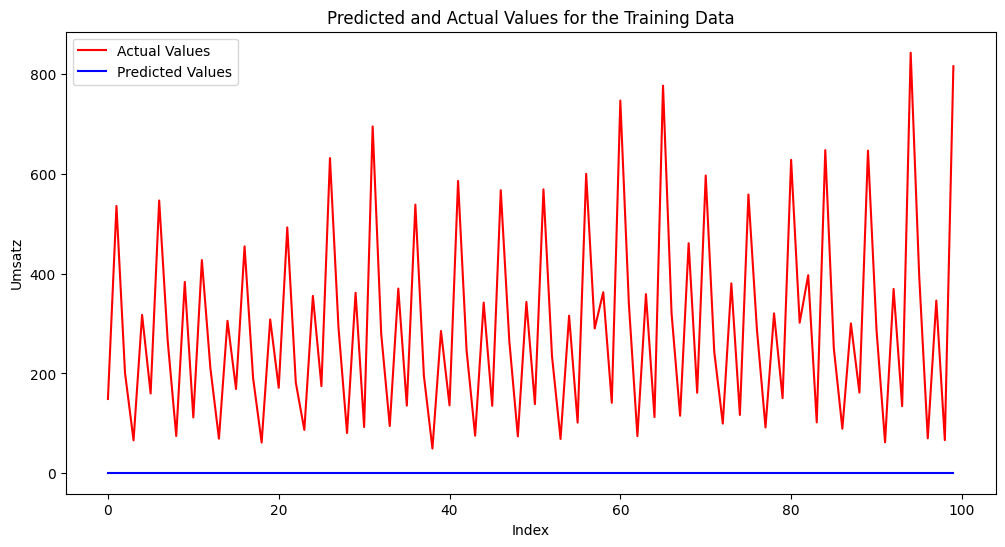

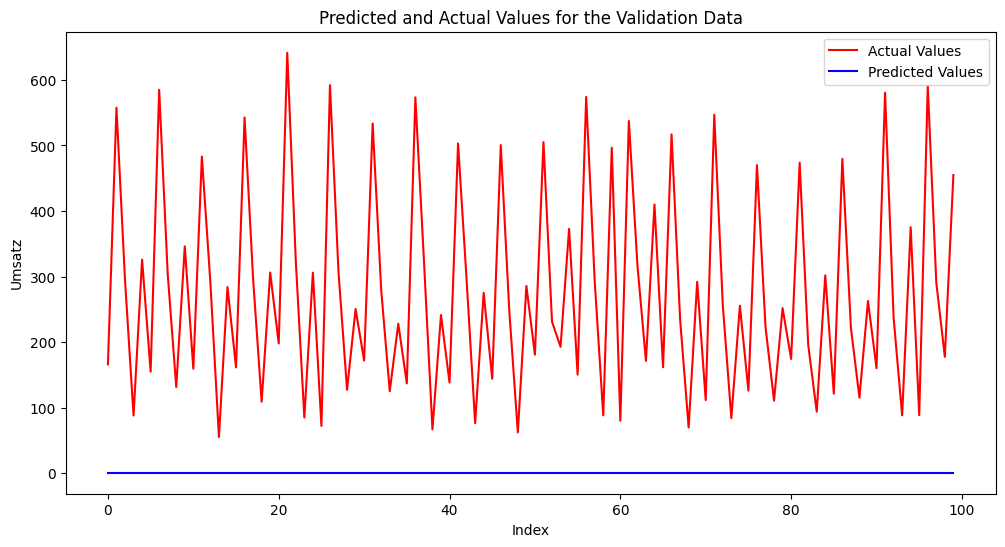

In [4]:
#visualizing results
training_features = X_train_scaled
training_labels = y_train
validation_features = X_val_scaled
validation_labels = y_val

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")
def plot_predictions(predictions, actual, title, dates=None):
    """
    Plots predicted vs. actual values.

    predictions : np.array oder pd.Series
        Vorhersagen des Modells
    actual : np.array oder pd.Series
        Tatsächliche Werte
    title : str
        Titel des Plots
    dates : pd.Series oder None
        Optional: Datumswerte für X-Achse
    """
    plt.figure(figsize=(12, 6))
    
    if dates is not None:
        x_axis = dates
        plt.plot(x_axis, actual, label='Actual Values', color='red')
        plt.plot(x_axis, predictions, label='Predicted Values', color='blue')
    else:
        x_axis = range(len(actual))
        plt.plot(x_axis, actual, label='Actual Values', color='red')
        plt.plot(x_axis, predictions, label='Predicted Values', color='blue')
    
    plt.title(title)
    plt.xlabel('Date' if dates is not None else 'Index')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()


# Flatten arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# Create DataFrames
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot first 100 cases for training
plot_predictions(data_train['prediction'].head(100), 
                 data_train['actual'].head(100), 
                 'Predicted and Actual Values for the Training Data')

# Plot first 100 cases for validation
plot_predictions(data_validation['prediction'].head(100), 
                 data_validation['actual'].head(100), 
                 'Predicted and Actual Values for the Validation Data')